In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.callbacks import ReduceLROnPlateau
from dataclasses import dataclass

In [2]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)  
DATA_DIR = "C:\\Users\\Kirtanaa\\Downloads\\archive"  
NUM_CLASSES = 4  

In [3]:

train_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,  
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

validation_dataset = tf.keras.utils.image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

Found 40384 files belonging to 2 classes.
Using 32308 files for training.
Found 40384 files belonging to 2 classes.
Using 8076 files for validation.


In [4]:

def preprocess_and_categorical(image, label):
    image = tf.keras.layers.Rescaling(1./255)(image)  
    label = tf.one_hot(label, depth=NUM_CLASSES)  
    return image, label

In [5]:

train_dataset = train_dataset.map(preprocess_and_categorical)
validation_dataset = validation_dataset.map(preprocess_and_categorical)
test_dataset = test_dataset.map(preprocess_and_categorical)

In [6]:

for images, labels in train_dataset.take(1):
    print(f'Train images shape: {images.shape}')
    print(f'Train labels shape: {labels.shape}')  

for images, labels in validation_dataset.take(1):
    print(f'Validation images shape: {images.shape}')
    print(f'Validation labels shape: {labels.shape}')  

for images, labels in test_dataset.take(1):
    print(f'Test images shape: {images.shape}')
    print(f'Test labels shape: {labels.shape}')  

Train images shape: (32, 224, 224, 3)
Train labels shape: (32, 4)
Validation images shape: (32, 224, 224, 3)
Validation labels shape: (32, 4)
Test images shape: (32, 224, 224, 3)
Test labels shape: (32, 4)


In [7]:
@dataclass(frozen=True)
class DatasetConfig:
    NUM_CLASSES: int = 4  
    IMG_HEIGHT: int = 224
    IMG_WIDTH: int = 224
    NUM_CHANNELS: int = 3

@dataclass(frozen=True)
class TrainingConfig:
    EPOCHS: int = 4
    BATCH_SIZE: int = BATCH_SIZE
    LEARNING_RATE: float = 0.0001

In [8]:

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# Freeze all but the last 4 layers
for layer in base_model.layers[:-4]:
    layer.trainable = False


model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(512, activation='relu'),
    Dropout(0.3),
    BatchNormalization(),
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(NUM_CLASSES, activation='softmax')
])

In [9]:

optimizer = Adam(learning_rate=TrainingConfig.LEARNING_RATE)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [10]:

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=TrainingConfig.EPOCHS,
    callbacks=[lr_scheduler],
    verbose=1
)

Epoch 1/4
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 8588s 8s/step - accuracy: 0.8682 - loss: 0.3590 - val_accuracy: 0.9938 - val_loss: 0.0228 - learning_rate: 1.0000e-04
Epoch 2/4
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 8811s 9s/step - accuracy: 0.9887 - loss: 0.0346 - val_accuracy: 0.9970 - val_loss: 0.0111 - learning_rate: 1.0000e-04
Epoch 3/4
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 7760s 8s/step - accuracy: 0.9931 - loss: 0.0200 - val_accuracy: 0.9468 - val_loss: 0.1586 - learning_rate: 1.0000e-04
Epoch 4/4
1010/1010 ━━━━━━━━━━━━━━━━━━━━ 6321s 6s/step - accuracy: 0.9947 - loss: 0.0160 - val_accuracy: 0.9946 - val_loss: 0.0151 - learning_rate: 1.0000e-04


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
Predicted Class: NonDemented


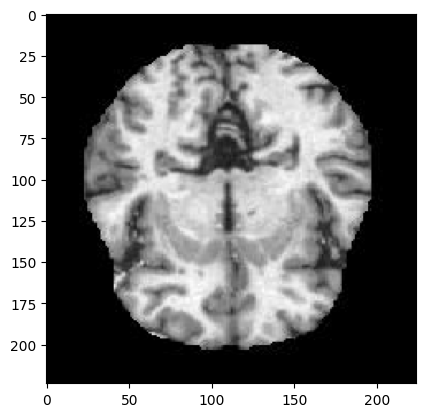

In [28]:
from tensorflow.keras.utils import load_img, img_to_array
import numpy as np

# Path to the image you want to predict
image_path = "C:\\Users\\Kirtanaa\\Downloads\\archive\\OriginalDataset\\NonDemented\\nonDem96.jpg"

# 1. Load and preprocess the image
img = load_img(image_path, target_size=(224, 224))  # Resize to the input size of the model
img_array = img_to_array(img) / 255.0  # Convert to array and normalize to [0, 1]
img_array = np.expand_dims(img_array, axis=0)  # Add a batch dimension

# 2. Predict the class
predictions = model.predict(img_array)  # Use the trained model instance
predicted_class = np.argmax(predictions[0])  # Get the index of the highest probability

# 3. Map the predicted index to the class names
class_names = ["VeryMildDemented", "NonDemented","Moderate Demented","Mild Dementia"]
print(f"Predicted Class: {class_names[predicted_class]}")
plt.imshow(img)

In [33]:
from sklearn.metrics import classification_report, f1_score, accuracy_score
import numpy as np

# 1. Evaluate the model on the test dataset (TensorFlow built-in)
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=1)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# 2. Calculate F1-score using scikit-learn
# Get true labels and predicted labels
y_true = []
y_pred = []

for images, labels in test_dataset:
    # True labels (one-hot to integer)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    
    # Predicted labels
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)


accuracy = accuracy_score(y_true, y_pred)
print(f"Accuracy (sklearn): {accuracy * 100:.2f}%")


f1 = f1_score(y_true, y_pred, average='weighted')  # Use 'weighted' for imbalanced datasets
print(f"F1-Score (Weighted): {f1:.2f}")

from sklearn.metrics import classification_report
import numpy as np

unique_classes = np.unique(np.concatenate([y_true, y_pred]))

class_map = {0: "VeryMildDemented", 1: "NonDemented", 2: "ModerateDemented", 3: "MildDemented"}
detected_names = [class_map[c] for c in unique_classes]


report = classification_report(y_true, y_pred, target_names=detected_names)
print("Classification Report:\n", report)


126/126 ━━━━━━━━━━━━━━━━━━━━ 754s 6s/step - accuracy: 0.9956 - loss: 0.0146
Test Accuracy: 99.33%
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/

126/126 ━━━━━━━━━━━━━━━━━━━━ 842s 7s/step
Unique Classes: [0 1]


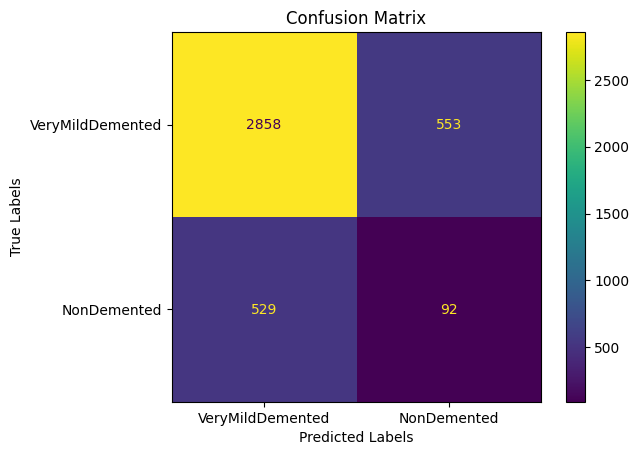

In [37]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Predict on the test dataset
y_pred_probs = model.predict(test_dataset)  # Predict probabilities for each class
y_pred = np.argmax(y_pred_probs, axis=1)    # Convert probabilities to class indices

# Get the true labels from the test dataset
y_true = []
for _, labels in test_dataset:  # Iterate through the test dataset
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot encoded labels to indices
y_true = np.array(y_true)

# Check the unique classes in the data
unique_classes = np.unique(np.concatenate([y_true, y_pred]))
print(f"Unique Classes: {unique_classes}")

# Generate the confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Display the confusion matrix with appropriate labels
display_labels = ["VeryMildDemented", "NonDemented", "ModerateDemented", "MildDemented"][:len(unique_classes)]
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=display_labels)
disp.plot(cmap="viridis")  # Customize colormap
disp.ax_.set_title("Confusion Matrix")  # Add a title
disp.ax_.set_xlabel("Predicted Labels")
disp.ax_.set_ylabel("True Labels")
plt.show()

